# Gaussian Processes Regresion and its Applications

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import mkl

from IPython.display import display, HTML
from matplotlib.animation import FuncAnimation

np.random.seed(1234)
mkl.set_num_threads(4)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

## Usefull imports

In [53]:
import scipy.special

from scipy.stats import multivariate_normal as mvn
from scipy.stats import norm as norm
from scipy.stats import uniform as uniform

from numpy.linalg import inv

## Useful utility functions

In [54]:
def plot_gp_samples(ax, x, F, title=None):
    '''
    Plot samples from a 1D Gaussian process.
    
    Args:
        ax:    Axis for plotting.
        x:     x coordinates.
        F:     Samples from a Gaussian process,
               shape: n_samples times len(x).
        title: Plot title.
    '''
    colors = ['r', 'g', 'b', 'c', 'm']
    
    if F.ndim == 1:
        F = F.reshape(1, -1)
        
    for y, c in zip(F, colors):
        ax.plot(x, y, marker='', lw=2.0, color=c)
    
    ax.set_xlabel(r'$x$', fontsize='xx-large')
    ax.set_ylabel(r'$f(x)$', fontsize='xx-large')
    
    if title is not None:
        ax.set_title(title)

In [55]:
def plot_gpr(ax, V, mu, Sigma, U, f_U, y, sigma, title=None):
    '''
    Plot Gaussian Process Regression results.
    
    Args:
        ax:    Axis for plotting.
        V:     Regression points.
               shape m times 1.
        mu:    Expected value of f(V),
               shape: m times 1.
        Sigma: Covariance of f(V),
               shape: m times m.
        U:     Points at which values of f were observed,
               shape: n times 1.
        f_U:   True values of f(U),
               shape: n times 1.
        y:     Noisy observations of f(U),
               shape: n times 1.
        sigma: Assumed noise level (standard deviation of y).
        title: Plot title.
    
    Note:
        Normally, f(U) is not know (observations are noisy). We use it
        only to illustrate regression results.
    '''
    ax.plot(V, mu, marker='', lw=2.0, color='r')
    
    f_V_2sigma = 2 * np.sqrt(np.diag(Sigma))
    
    V, mu = V.squeeze(), mu.squeeze()
    plt.fill_between(V, mu + f_V_2sigma, mu - f_V_2sigma, alpha=0.3)
    
    ax.scatter(U, y, s=100, c='g', marker='x', zorder=2)
    ax.errorbar(U, f_U, sigma, None, marker="o", ls='', capsize=5)

    ax.set_xlabel(r'$x$', fontsize='xx-large')
    ax.set_ylabel(r'$f(x)$', fontsize='xx-large')
    
    if title is not None:
        ax.set_title(title)

## Covariance functions

We begin by defining several covariance functions.

In [56]:
def sqdist(X, Y):
    '''
    Calculate all-to-all squared distances between points in X and Y.
    
    Args:
        X: Point coordinates,
           shape: n times d.
        Y: Point coordinates,
           shape: m times d.
    
    Returns:
        n times m matrix with squared Euclidean distances.
    '''
    X2 = np.sum(X * X, axis=1, keepdims=True)
    Y2 = np.sum(Y * Y, axis=1, keepdims=True)
    
    return X2 + Y2.T - 2 * X @ Y.T

- White noise kernel:

    $$\large
    k\left(\mathbf{x}, \mathbf{y}\right) = \begin{cases}
                                              \sigma^2 & \textrm{if } \mathbf{x} = \mathbf{y} \\
                                              0        & \textrm{if } \mathbf{x} \neq \mathbf{y}
                                             \end{cases}$$

In [57]:
def white_noise_kernel(X, Y, sigma=1.0):
    return np.where(sqdist(X, Y) == 0, sigma **2, 0)

- Gaussian kernel:

    $$\large
     k\left(\mathbf{x}, \mathbf{y}\right) =
      \exp\left(-\frac{\left\|\mathbf{x} - \mathbf{y}\right\|^2}
                      {2l^2}\right)$$

In [58]:
def gaussian_kernel(X, Y, l=1.0):
    return np.exp( -sqdist(X, Y) / (2 * l ** 2))

- Periodic kernel:

    $$\large
     k\left(\mathbf{x}, \mathbf{y}\right) =
      \exp\left(
        -\frac{2}{l^2}
        \sin^2\left(
          \frac{\pi \left\|\mathbf{x} - \mathbf{y}\right\|}{p}
        \right)
      \right)$$

In [59]:
def periodic_kernel(X, Y, l=1.0, p=1.0):
    return np.exp(-(2 / l ** 2) * np.sin(np.pi * np.sqrt(sqdist(X, Y)) / p) ** 2)

- Matérn kernel:

    $$\large
    k\left(\mathbf{x}, \mathbf{y}\right) =
      \frac{2^{1-\nu}}{\Gamma(\nu)}
      \left(\sqrt{2\nu}
            \frac{\left\|\mathbf{x} - \mathbf{y}\right\|}{l}
      \right)^\nu
      K_\nu\left(
        \sqrt{2\nu}
        \frac{\left\|\mathbf{x} - \mathbf{y}\right\|}{l}
      \right)$$

In [60]:
def matern_kernel(X, Y, l=1.0, nu=0.5):
    D = np.sqrt(sqdist(X, Y))
    D[D == 0.0] += np.finfo(float).eps
    
    Q = np.sqrt(2 * nu) * D / l
    
    K = Q ** nu
    K *= (2 ** (1. - nu)) / scipy.special.gamma(nu)
    K *= scipy.special.kv(nu, Q)
    
    return K

## Gaussian Processes

Now, lets sample some functions from Gaussian processes defined by these covariance functions. Formally, we calculate:

$$ \large
  \begin{aligned}
     f & \sim GP \left(\mathbf{0}, k\right) \\
     \mathbf{f_X} & = f\left(\mathbf{X}\right)
   \end{aligned}
$$

and then plot: $\left(\mathbf{X}, \mathbf{f_X}\right)$.

Implement `sample_gp` function which takes as an input:

- An array `X` of point coordinates, with shape: $n \times d$.
- A covariance function: `kernel`.
- Number of samples to draw from the Gaussian process: `n_samples`.
- Additional arguments for the covariance function: `kernel_args`.

and returns samples from the Gaussian process evaluated at `X`. The result should be a NumPy array with shape: $n\_samples \times n$.

In [61]:
def sample_gp(X, kernel=gaussian_kernel, samples=1, **kernel_args):
    mu = np.zeros(X.shape[0])
    Sigma = kernel(X, X, **kernel_args)
    return mvn.rvs(mean = mu, cov = Sigma, size = samples)

Lets draw samples from a 1D Gaussian process. Samples will be evaluated at `n_points` spaced equally between `xmin` and `xmax`.

In [62]:
n_points = 200
xmin, xmax = -5.0, 5.0

X = np.linspace(xmin, xmax, n_points).reshape(-1, 1)

Samples from a Gaussian process with white noise covariance.

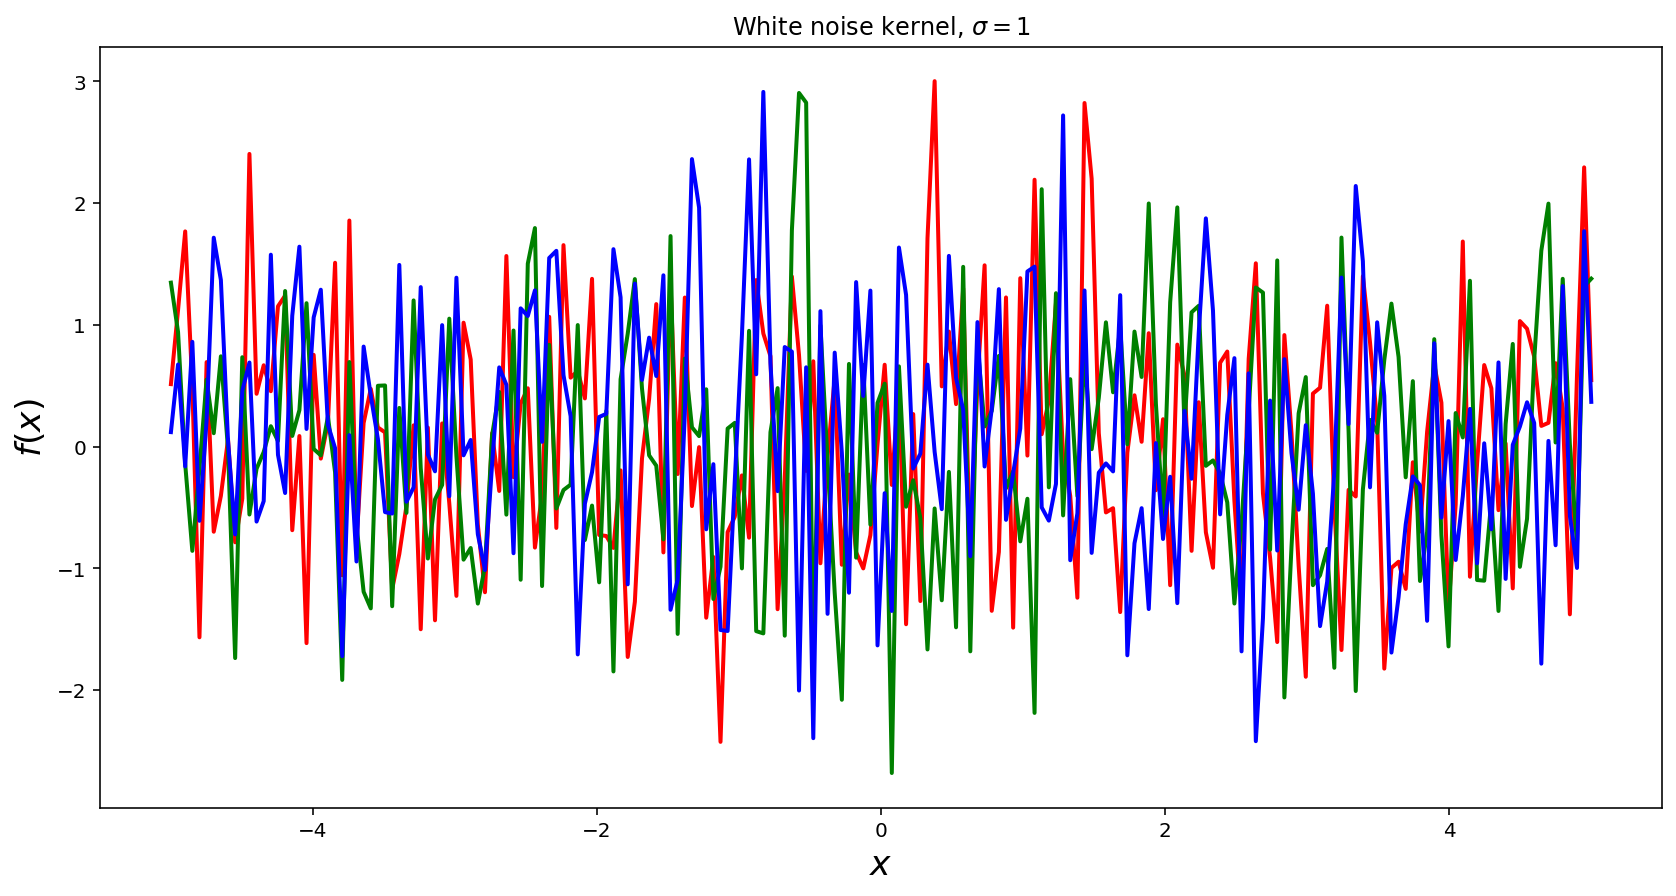

In [63]:
f = sample_gp(X, kernel=white_noise_kernel, samples=3, sigma=1)

fig = plt.figure(figsize=(14, 7))
plot_gp_samples(plt.gca(), X, f, r'White noise kernel, $\sigma=1$')

Samples from a Gaussian process with Gaussian covariance.

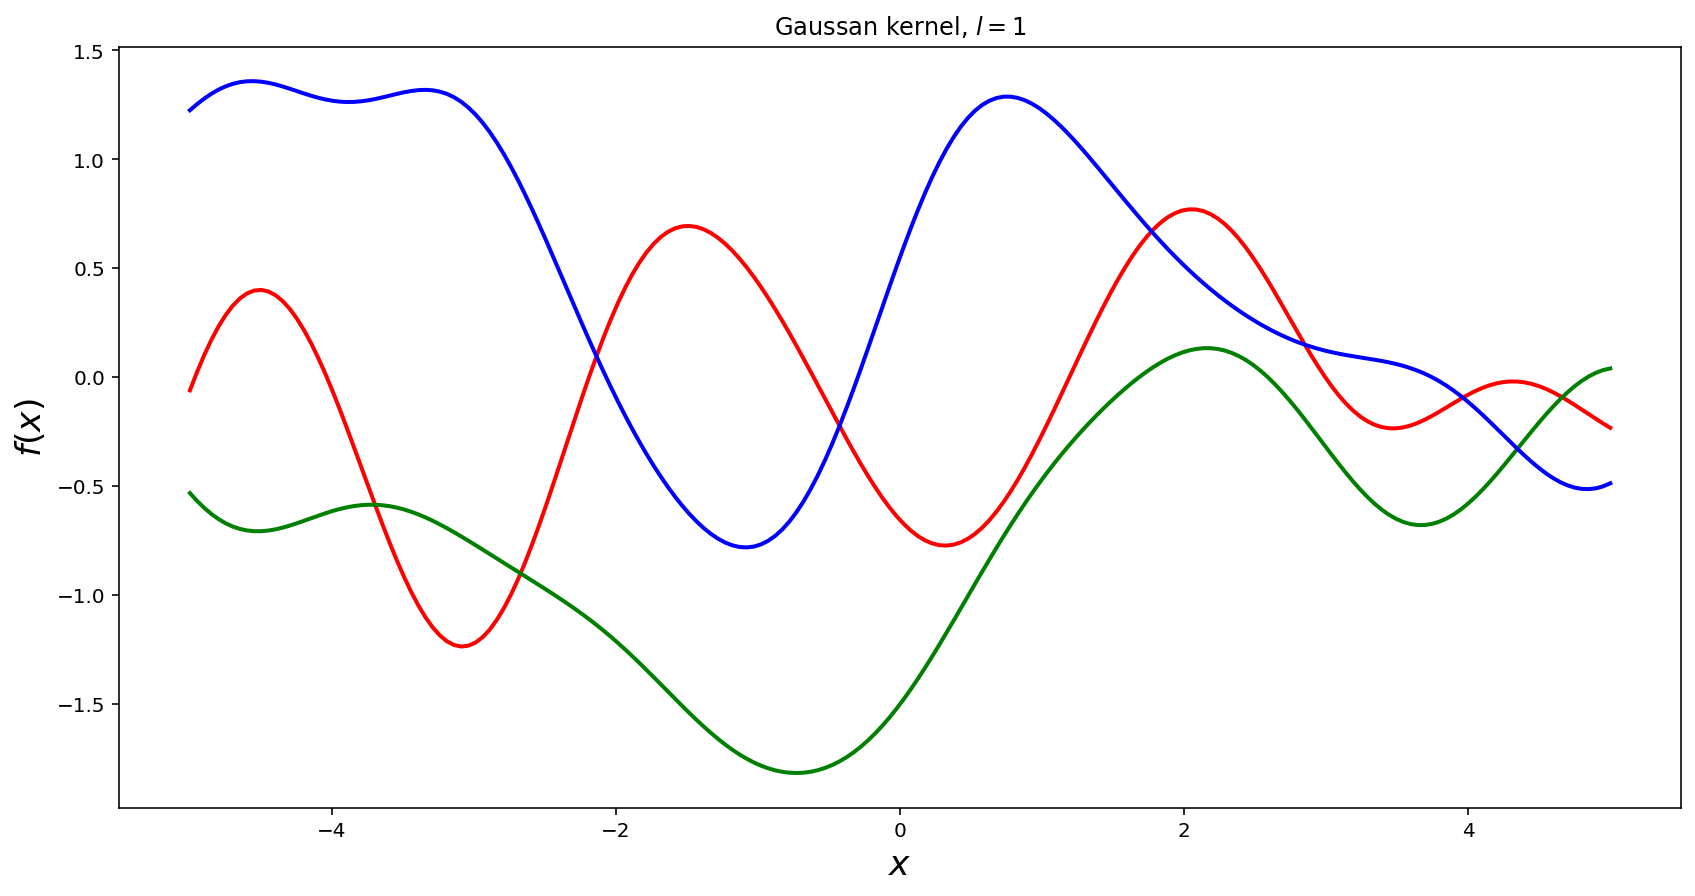

In [64]:
f = sample_gp(X, kernel=gaussian_kernel, samples=3, l=1)

fig = plt.figure(figsize=(14, 7))
plot_gp_samples(plt.gca(), X, f, r'Gaussan kernel, $l=1$')

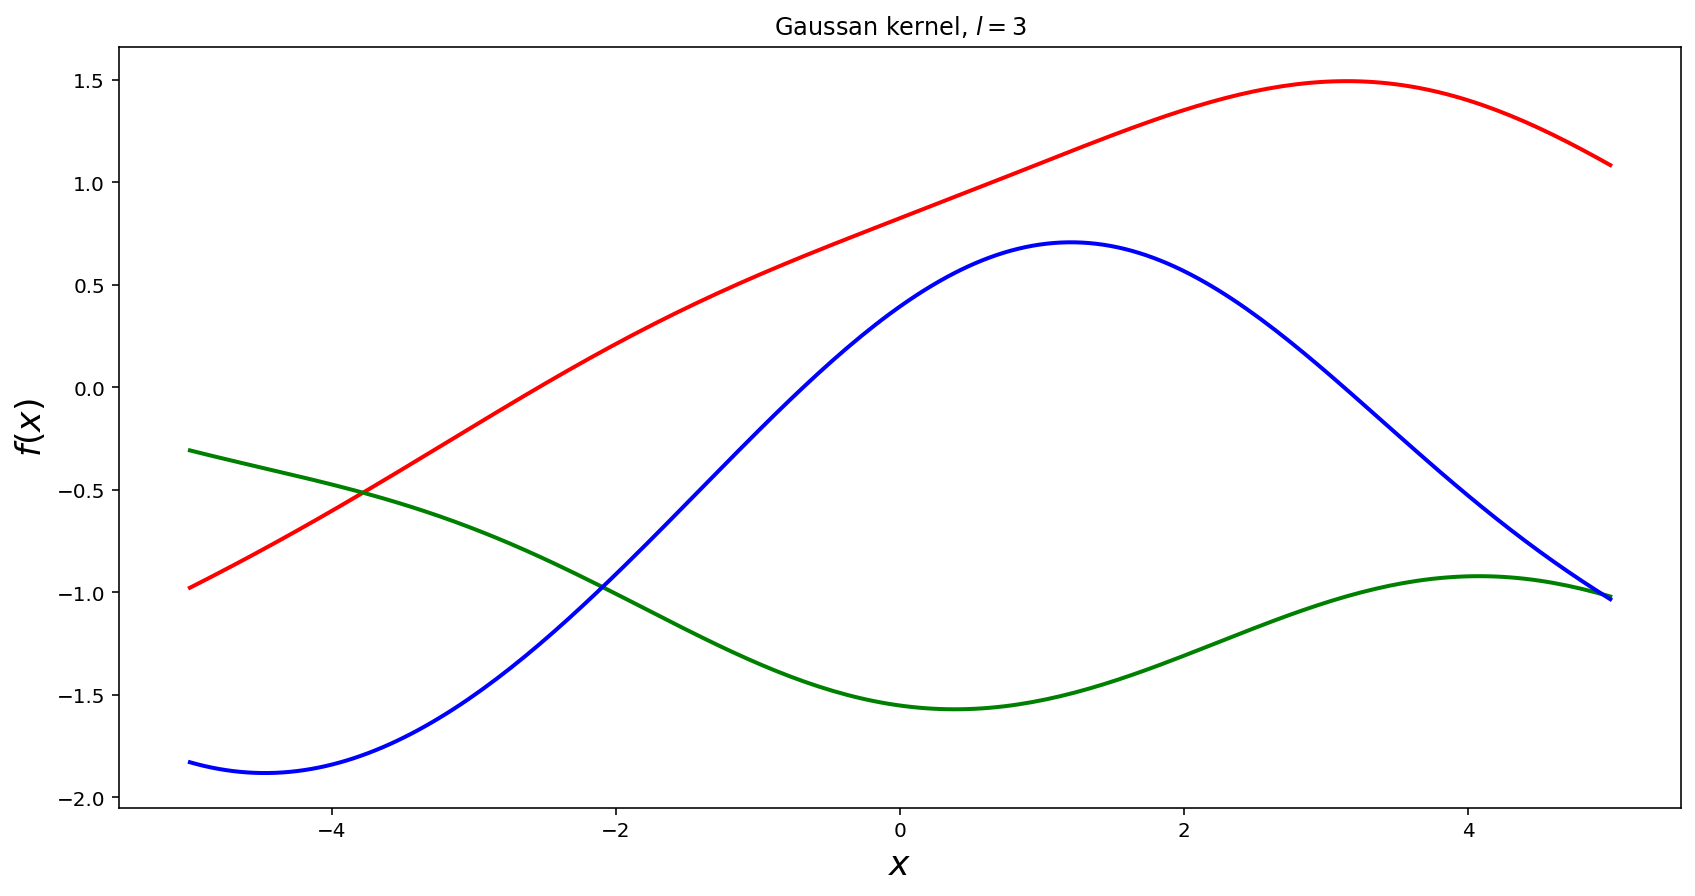

In [65]:
f = sample_gp(X, kernel=gaussian_kernel, samples=3, l=3)

fig = plt.figure(figsize=(14, 7))
plot_gp_samples(plt.gca(), X, f, r'Gaussan kernel, $l=3$')

Samples from a Gaussian process with periodic covariance.

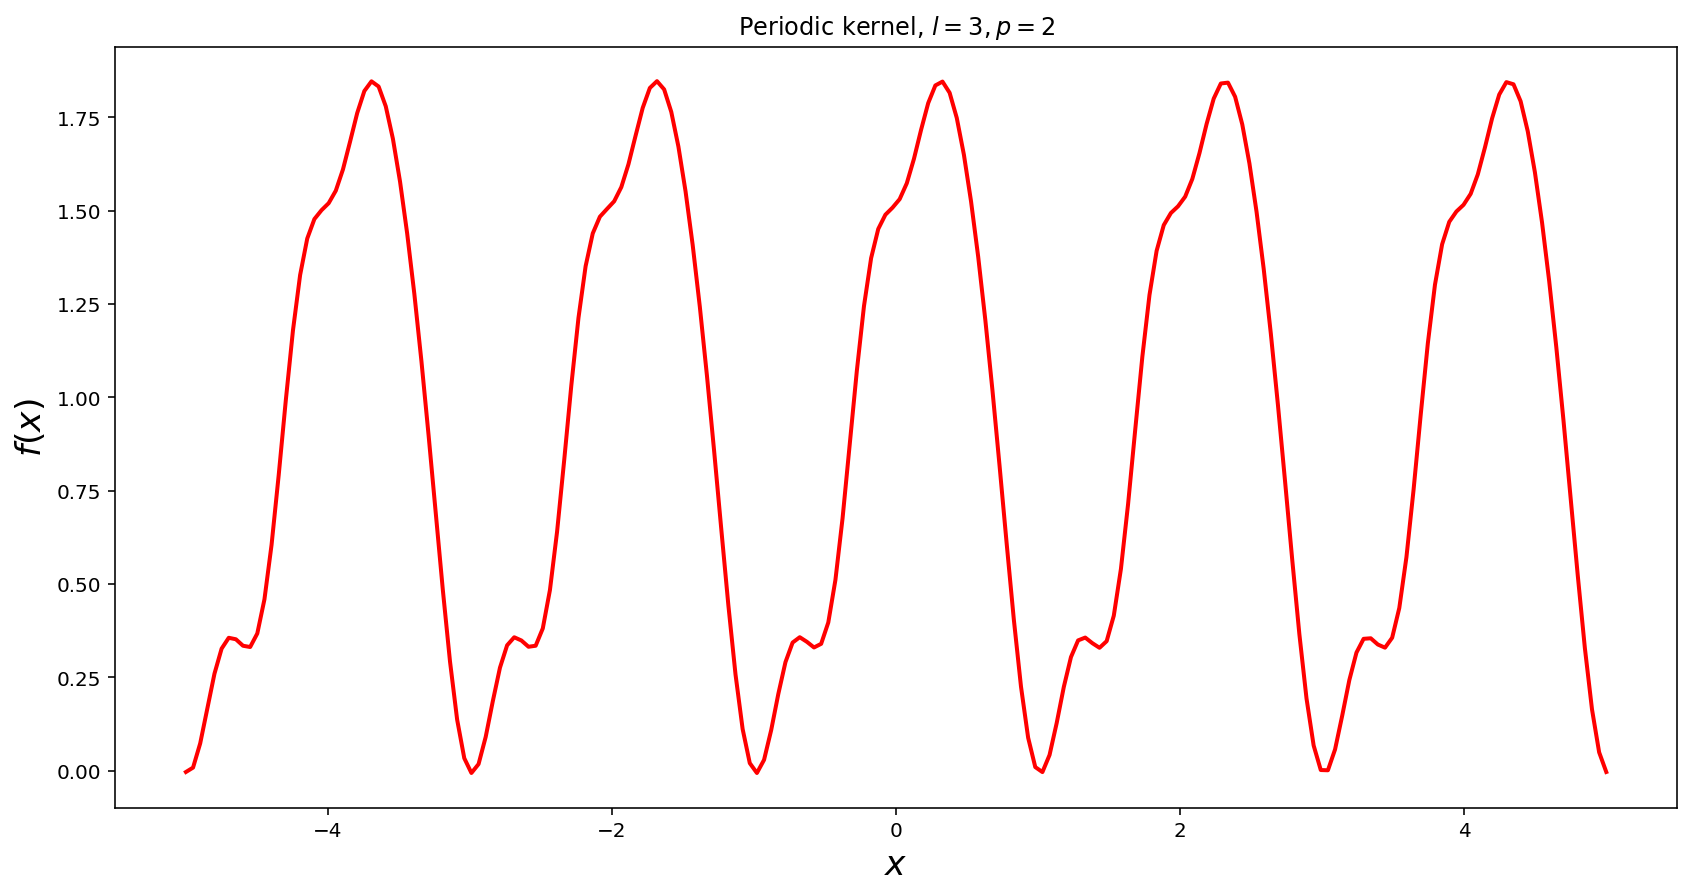

In [66]:
f = sample_gp(X, kernel=periodic_kernel, samples=1, l=1, p=2)

fig = plt.figure(figsize=(14, 7))
plot_gp_samples(plt.gca(), X, f, r'Periodic kernel, $l=3, p=2$')

Samples from a Gaussian process with Matérn covariance.

- with $\nu = 0.5$ Matérn covariance is equivalent to the so-called *absolute exponential covariance function*.

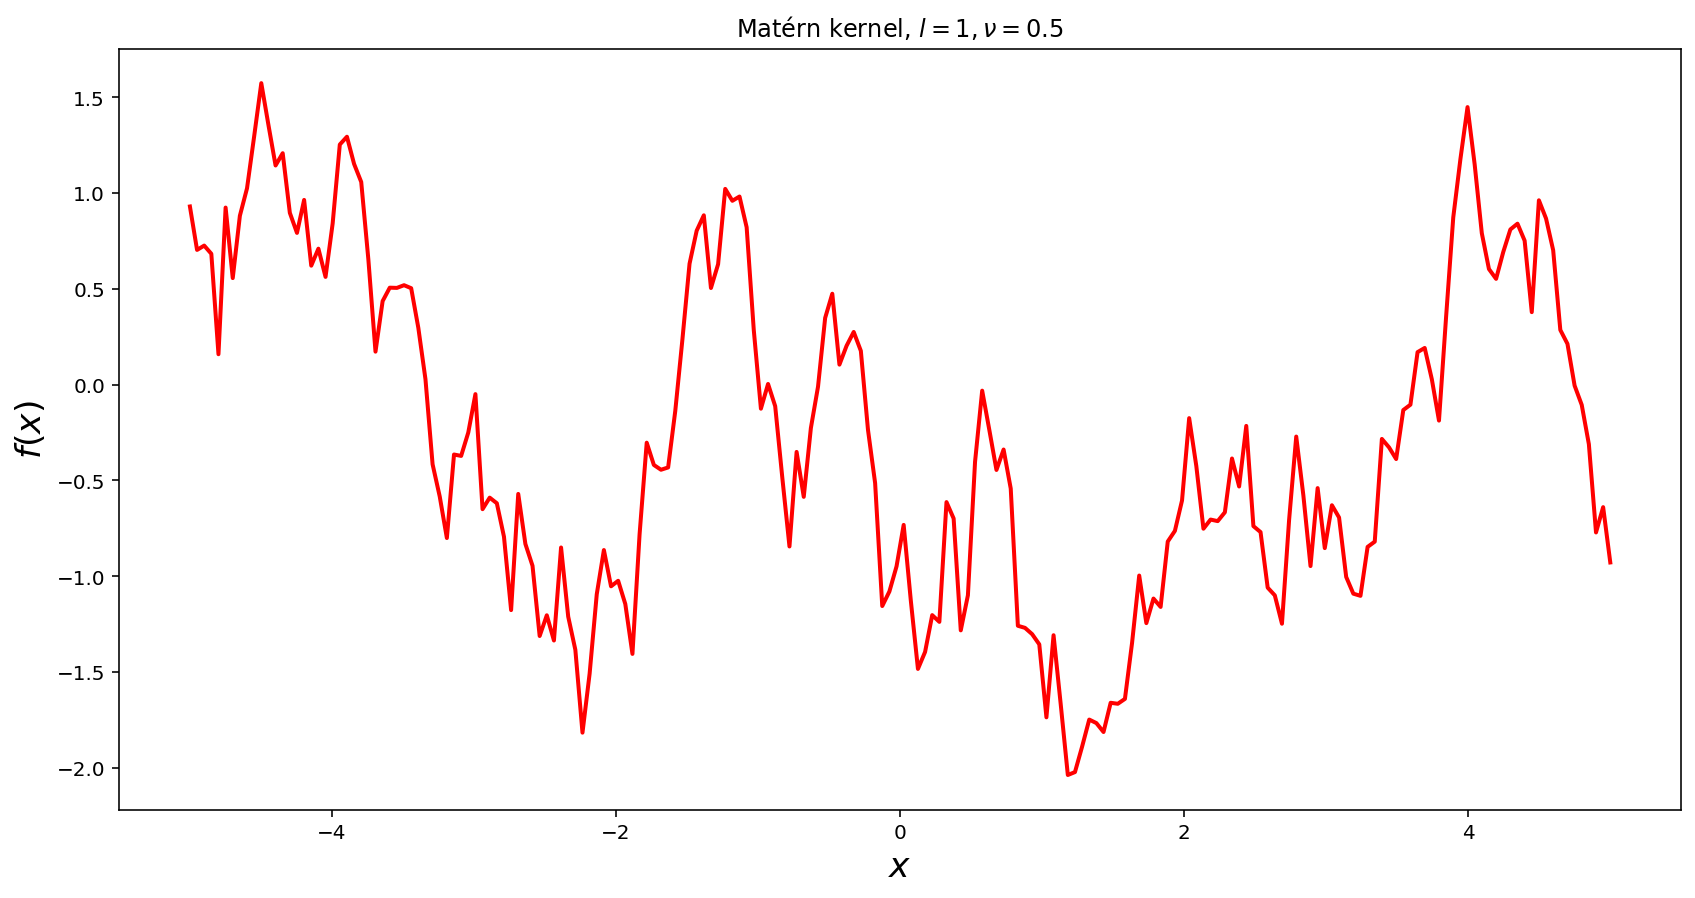

In [67]:
f = sample_gp(X, kernel=matern_kernel, samples=1, l=1, nu=0.5)

fig = plt.figure(figsize=(14, 7))
plot_gp_samples(plt.gca(), X, f, r'Matérn kernel, $l=1, \nu=0.5$')

- with $\nu = 1.5$ samples from the Gaussian process (with Matérn covariance) are once differentiable.

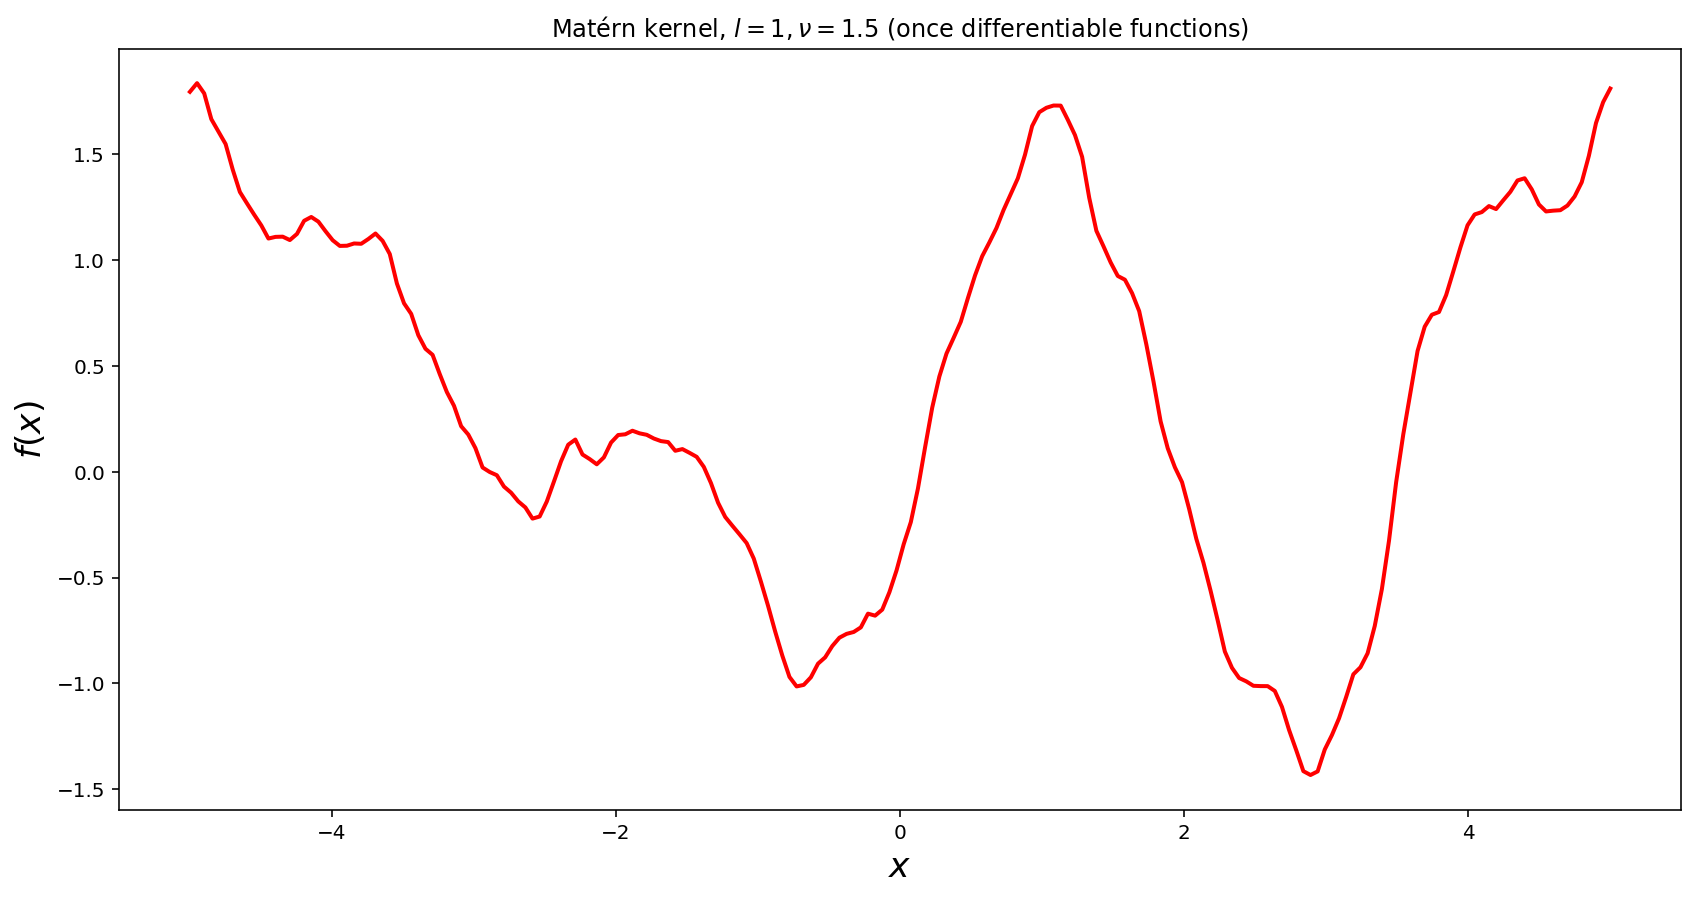

In [68]:
f = sample_gp(X, kernel=matern_kernel, samples=1, l=1, nu=1.5)

fig = plt.figure(figsize=(14, 7))
plot_gp_samples(plt.gca(), X, f, r'Matérn kernel, $l=1, \nu=1.5$ (once differentiable functions)')

- with $\nu = 2.5$ samples from the Gaussian process (with Matérn covariance) are twice differentiable.

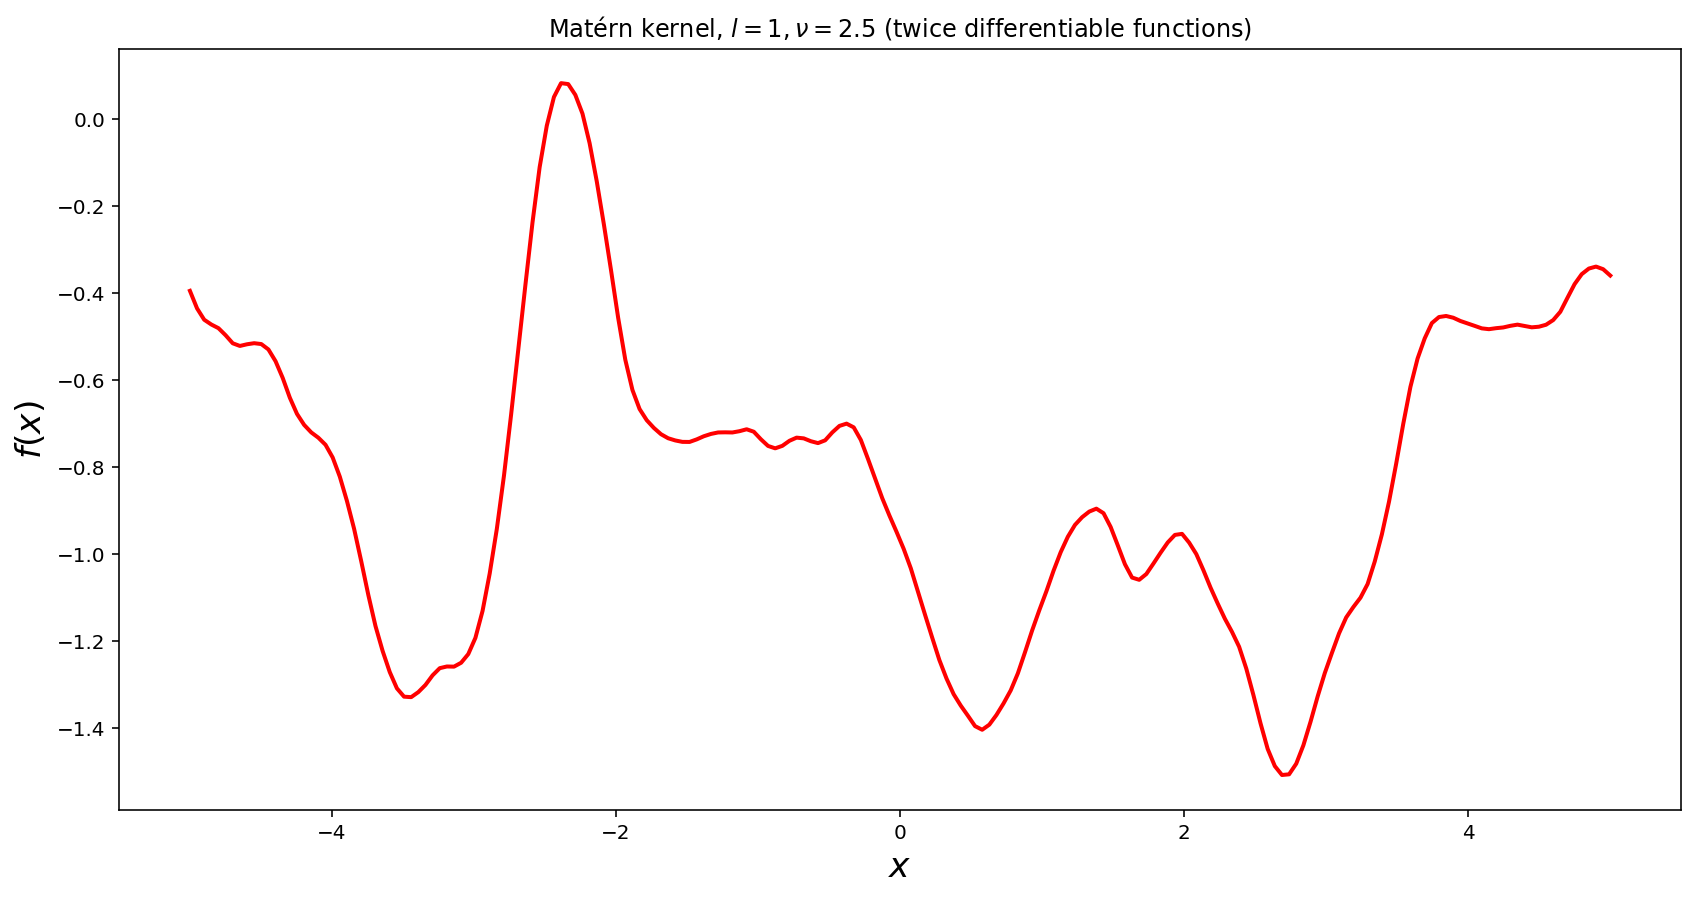

In [69]:
f = sample_gp(X, kernel=matern_kernel, samples=1, l=1, nu=2.5)

fig = plt.figure(figsize=(14, 7))
plot_gp_samples(plt.gca(), X, f, r'Matérn kernel, $l=1, \nu=2.5$ (twice differentiable functions)')

- when $\nu \to \infty $ Matérn covariance converges to the Gaussian covariance.

## Gaussian Process Regression

Now, lets assume we have a set of noisy evaluations of some unknown function $f$:

$$\large
\begin{aligned}
  \mathbf{y} & = f\left(\mathbf{X}\right) + \boldsymbol\epsilon \\
  \boldsymbol\epsilon & \sim N \left(\mathbf{0}, \sigma^2\mathbf{I}\right)
\end{aligned}$$

where $\mathbf{X} = \left\{\mathbf{x}_1, \mathbf{x}_2, \mathbf{x}_1, \ldots, \mathbf{x}_n\right\}$.

Our goal is to approximate $f$ using a Gaussian process. That is, we want to learn a posterior distribution over functions that approximate $f$.

Implement `gp_regression` function which takes as an input:

- An array `V` of point coordinates, with shape: $m \times d$.<br>
  These are the points at which we want to evaluate expected value of $f$.
- An array `U` of point coordinates, with shape: $n \times d$.<br>
  These are the points at which we know noisy evaluations of $f$.
- An array `y` of real values, with shape: $n \times 1$.<br>
  These are the noisy observations of $f(\mathbf{U})$.
- Assumed noise level: `sigma` (standard deviation of `y`).
- A covariance function: `kernel`.
- Additional arguments for the covariance function: `kernel_args`.

and returns parameters of the posterior distribution over $f(\mathbf{V})$, i.e.:
- mean $\boldsymbol\mu_\mathbf{V}$ with shape $m \times 1$,
- covariance $\mathbf{\Sigma}_\mathbf{V}$ with shape $m \times m$.

In [70]:
def gp_regression(V, U, y, sigma, kernel=gaussian_kernel, **kernel_args):
    K_VU = kernel(V, U, **kernel_args)
    K_UU = kernel(U, U, **kernel_args)
    K_VV = kernel(V, V, **kernel_args)
    K_UV = kernel(U, V, **kernel_args)
    
    I = np.identity(U.shape[0])
    sigma_I = sigma ** 2 * I
    
    mu_v = K_VU @ inv(K_UU + sigma_I) @ y
    Sigma_v = K_VV - K_VU @ inv(K_UU + sigma_I) @ K_UV
    
    return mu_v, Sigma_v

Let's prepare some noisy obsewrvations of $f(\mathbf{U})$:

In [71]:
U   = np.array([-1.5, 0.4, 0.9, 2.0, 3.5]).reshape(-1, 1)  # points where we sample f
F_U = np.array([2.0,  0.1, 0.4, 1.8, 0.5]).reshape(-1, 1)  # true (unobserved) values of f

sigma = 0.25  # measurement noise

y = mvn.rvs(mean=np.squeeze(F_U), cov=sigma).reshape(-1, 1)  # noisy measurements of f(U)

We will approximate $f$ at `N` points spaced equally between `xmin` and `xmax`:

In [72]:
N = 100
xmin, xmax = -6.0, 6.0

V = np.linspace(xmin, xmax, N).reshape(-1, 1)

We can now use Gaussian Process Regression to caculate posterior distribution over $f(\mathbf{V})$.

We will plot the expected value of $f(\mathbf{V})$ and its two standard deviations band. We will also plot (unobserved) true values of $f(\mathbf{U})$ and noisy observations $\mathbf{y}$.

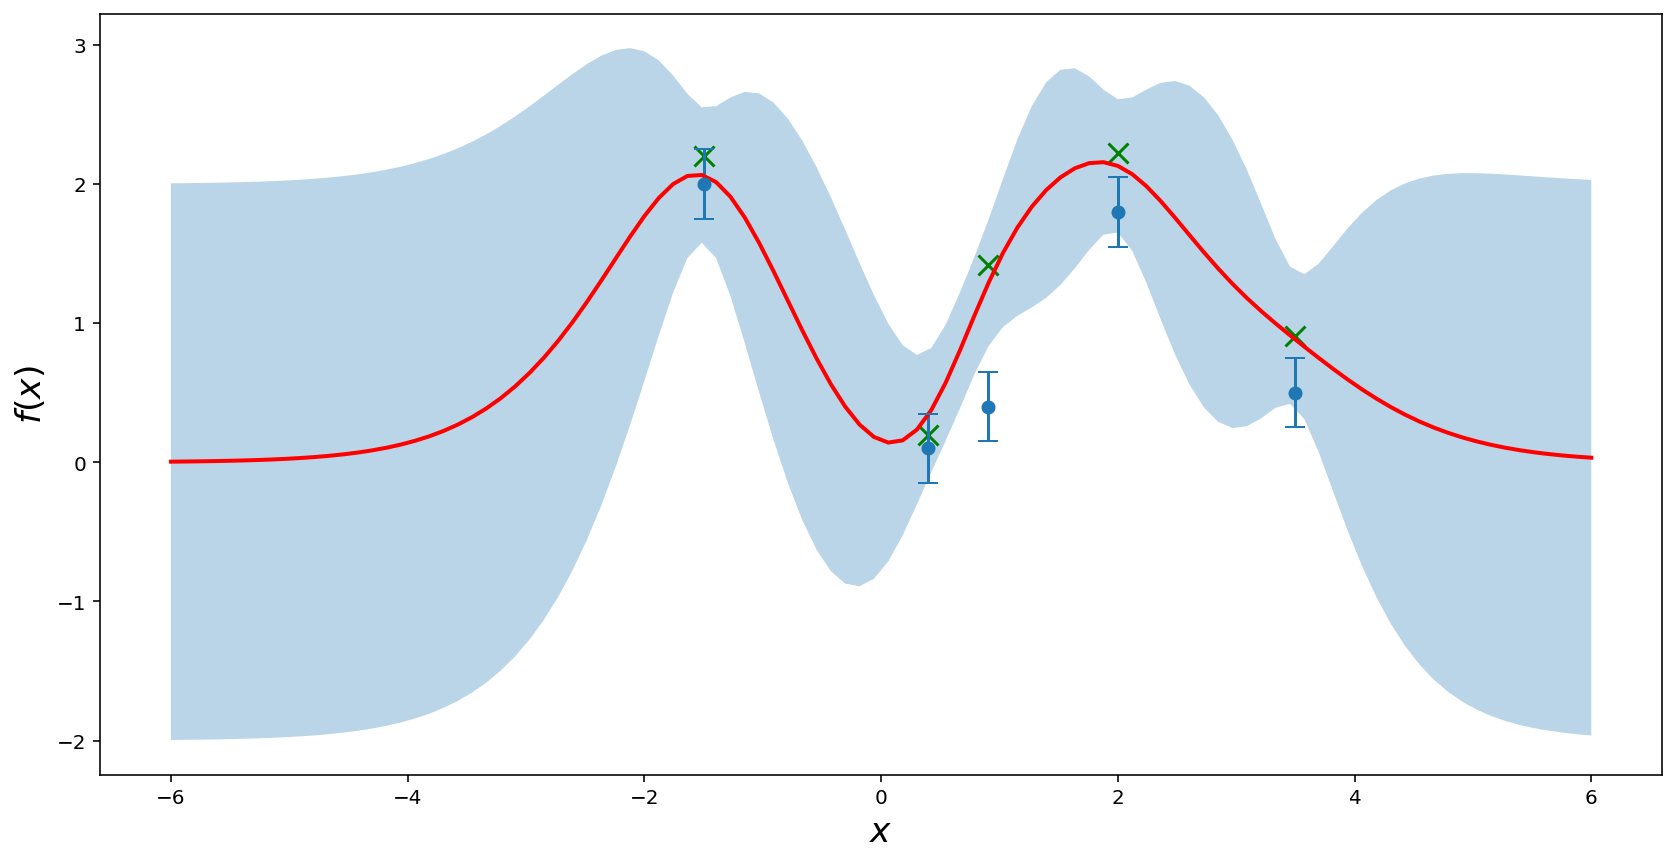

In [73]:
mu_V, Sigma_V = gp_regression(V, U, y, sigma, kernel=matern_kernel, l=1.0, nu=2.5)

fig = plt.figure(figsize=(14, 7))
plot_gpr(plt.gca(), V, mu_V, Sigma_V, U, F_U, y, sigma)

## Example Application: Bayesian Optimization

We will now present an interesting application of Gaussian Process Regression: ***Bayesian Optimization***.

Imagine we want to minimize some complicated function $f(\mathbf{x})$. We assume that:
1. Evaluating $f$ is very expensive. We can afford to evaluate $f$ only few dozen - perhaps few hundreds - of times.
1. We only have noisy measurements of $f(\mathbf{x})$. Calculating exact value of $f(\mathbf{x})$ is hard.
1. $f$ is a *black-box* function. We can sample values of $f$ and perhaps have some intuitions about it smoothness, periodicity, etc. But other than that, we don't know anything about $f$.

Example:
- $\mathbf{x}$ is a vector of training hyper-parameters for a neural network (learning rate, regularization constants, etc.),
- $f(\mathbf{x})$ is the error rate of a neural network trained using hyper-parameters $\mathbf{x}$.

To evaluate $f(\mathbf{x})$ we need to train a neural network using hyper-parameters $\mathbf{x}$ and then estimate its rate of errors on some validation dataset. This is expensive. Furthermore, we never get an exact error rate but only is noisy approximation (calculated on some finite validation set).

---

<u>The basic idea</u> is to approximate $f$ with a cheap-to-evaluate function $f^*$ and then work with this approximation. We will call $f^*$ a *surrogate function*.

To approximate $f$ we need samples of its values. But there is one problem: we cannot sample $f$ at will, because this is very expensive! So we need to guess just the *right* points at which we should sample $f$. What could be the *right* point to sample at?
- A point $\mathbf{x}$ where we expect $f$ to be lower that anything we sampled thus far (i.e. value of $f(\mathbf{x})$ is probably lower than the current minimum).
- A point $\mathbf{x}$ where we do not know much about $f$ (i.e. variance of $f(\mathbf{x})$ is high),
- And many other possibilities...

But this leads to another problem: how can we find the *right* point $\mathbf{x}$ to sample $f(\mathbf{x})$, when $f$ is an expensive *black-box* function?

<u>The second idea</u> is to use the *surrogate function* $f^*$ to select points $\mathbf{x}$ at which we will sample $f(\mathbf{x})$. In other words, the *surrogate function* is guiding the exploration of $f$.

This gives a following high-level algorithm:
1. Let $f^*$ be a probabilistic approximation of $f$, for example a Gaussian process posterior over $f$. This surrogate functions $f^*$ describes our current beliefs about $f$.
2. Sample few values of $f$ (e.g. at random points from the domain of $f$) and used them to make an initial approximation $f^*$.
3. Use current approximation $f^*$ to select $\mathbf{x}^*$ - the next point at which we will sample value of $f$.
4. Sample y = $f\left(\mathbf{x}^*\right)$ and update $f^*$ with the sampled value: $\left(\mathbf{x}^*, y\right)$.
5. Repeat points 3-4 until a stop criterion (e.g. whole computational budget allocated for minimization was used).

---

There is one important detail left: how exactly do we use $f^*$ to find the *right* point $\mathbf{x}^*$ at which we should sample $f$?

$f^*$ expresses our current belief about $f$ - this is the reason why $f^*$ is a probabilistic approximation of $f$. When selecting $\mathbf{x}^*$ we should account for:
- our expectations about values of $f$, and
- our uncertainty about values of $f$.

We will encapsulate these two concepts in an *acquisition function* $a\left(\mathbf{x}\right)$ and then select:

$$
\large
\mathbf{x}^* = \mathop{\mathrm{arg\,max}}_\mathbf{x} a\left(\mathbf{x}\right)
$$

Note that we need to maximize the acquisition function. But this is vastly less expensive than optimization of $f$, because  acquisition function works with a cheap-to-evaluate approximation of $f$, namely the surrogate function $f^*$.

There are many useful acquisition functions. The simplest one is perhaps the ***probability of improvement***. Let $\hat{y}$ be the smallest value of $f$ found so far. The probability of improvement is defined as:

$$
\large
a_\textrm{PI}\left(\mathbf{x}\right) = P\left(f(\mathbf{x}) < \hat{y}\right)
$$

That is, $a_\textrm{PI}\left(\mathbf{x}\right)$ is a probability that $f(\mathbf{x})$ will be smaller than any value we've seen so far.

Probability of improvement has a closed-form solution under a Gaussian process approximation. Let's define an indicator function:

$$
\large
\mathcal{I}_{f(\mathbf{x}) < \hat{y}} = \begin{cases}
                                          1 & \textrm{if}\quad  f(\mathbf{x}) < \hat{y}, \\
                                          0 & \textrm{otherwise.}
                                        \end{cases}
$$

Then:

$$
\large
\begin{aligned}
  a_\textrm{PI}\left(\mathbf{x}\right) & = P\left(f(\mathbf{x}) < \hat{y}\right)
                                         = \mathbb{E}\left[\mathcal{I}_{f(\mathbf{x}) < \hat{y}}\right] \\
                                       & = \int_{-\infty}^{+\infty}
                                             \mathcal{I}_{f_\mathbf{x} < \hat{y}}\ 
                                             p \left(f_\mathbf{x} \mid \mathbf{y}, U\right)
                                             \mathrm{d}f_\mathbf{x} \\
                                       & = \int_{-\infty}^{\hat{y}}
                                             p \left(f_\mathbf{x} \mid \mathbf{y}, U\right)
                                             \mathrm{d}f_\mathbf{x} \\
                                       & = \int_{-\infty}^{\hat{y}}
                                             N \left(f_\mathbf{x} \mid \mu_{\mathbf{x}},
                                                                       \sigma_{\mathbf{x}}^2\right)
                                             \mathrm{d}f_\mathbf{x} \\
                                       & = \Phi \left(\hat{y} \mid \mu_{\mathbf{x}},
                                                                   \sigma_{\mathbf{x}}^2\right) \\
                                       & = \Phi \left(\frac{\hat{y} - \mu_{\mathbf{x}}}
                                                           {\sigma_{\mathbf{x}}} \mid 0, 1\right).           
\end{aligned}
$$

where:

- $\mathbf{y}$ is the vector of values of $f$ sampled thus far, and $U$ is the set of points at which we sampled $\mathbf{y}$.
- $\mu_{\mathbf{x}}$ and $\sigma_{\mathbf{x}}$ are the expected value and the standard deviation of $f(\mathbf{x})$ given the values observed thus far (i.e. given $\mathbf{y}$ and $U$). Because we use a Gaussian process to approximate $f$, the expected value $\mu_{\mathbf{x}}$ and the standard deviation $\sigma_{\mathbf{x}}$ are given by the Gaussian process regression:

$$
\large
f_\mathbf{x} \mid \mathbf{y}, U \sim N\left(\mu_{\mathbf{x}}, \sigma_{\mathbf{x}}^2\right).
$$

- $\Phi$ is the cumulative distribution function of a normal distribution.

---

Let's put these concepts into a code!

Implement `probability_of_improvement` function which takes as an input:

- An array `V` of point coordinates, with shape: $m \times d$.<br>
  These are the points $\mathbf{x}$ at which we want to evaluate the
  probability of improvement $a_\textrm{PI}\left(\mathbf{x}\right)$.
- An array `U` of point coordinates, with shape: $n \times d$.<br>
  These are the points at which we know noisy evaluations of $f$.
- An array `y` of real values, with shape: $n \times 1$.<br>
  These are the noisy observations of $f(\mathbf{U})$.
- Assumed noise level: `sigma` (standard deviation of `y`).
- A covariance function: `kernel`.
- Additional arguments for the covariance function: `kernel_args`.

and returns a tuple with:
- A NumPy array with probability of improvement values evaluated at points from `V`. The shape of the returned array should be $m \times 1$.
- A NumPy array with $\boldsymbol \mu_\mathbf{V}$, i.e. the expected value of $f\left(\mathbf{V}\right)$. The shape of the returned array should be $m \times 1$.

In [ ]:
def probability_of_improvement(V, U, y, sigma, kernel, **kernel_args):
    raise Exception('Implement probability_of_improvement function')

We need to find maximum of the acquisition function. In this example we will use a simple Monte Carlo maximization:
- we randomly select `n_samples` points from the domain of $f$,
- then evaluate acquisition function at this randomly selected points,
- and return minimum from these values.

In [ ]:
def opt_acquisition(aq_f, U, y, sigma, sample_points, 
                    kernel, **kernel_args):
    '''
    Maximize acquisition function with a simple Monte Carlo algorithm.
    
    Args:
        aq_f:  A handle to the acquisition function.
        U:     Points at which values of f were observed,
               shape: n times 1.
        y:     Noisy observations of f(U),
               shape: n times 1.
        sigma: Assumed noise level (standard deviation of y).
        sample_points: Handle to a function which selects random points
                       from the domain of f.
        kernel:        A handle to the covariance function.
        kernel_args:   Additional arguments for the covariance function.
    
    Returns:
        Point that maximizes the acquisition function and the expected
        value of f at that point.
    '''
    n_samples = 100
    V = sample_points(size=n_samples)
    
    a, mu_V = aq_f(V, U, y, sigma, kernel=kernel, **kernel_args)
    idx = np.argmax(a)
    
    return V[idx], mu_V[idx]

We can finally implement our Bayesian Optimization algorithm.

Complete the implementation of `bayes_opt` function following comments in the code.

In [ ]:
def print_log(step, x, f_x, y, opt_x, opt_y):
    '''
    A utility function used to display the progress of bayes_opt.
    '''
    log = 'Step {:3d}\tnext x: {:5.2f},   expected f: {:5.2f},   measured f: {:5.2f},   ' \
          'opt x: {:5.2f},   opt f: {:5.2f}'
    log = log.format(step, x.item(), f_x.item(), y.item(),
                     opt_x.item(), opt_y.item())
    
    print(log)


def bayes_opt(f, sample_points, steps=20, kernel=matern_kernel, **kernel_args):
    '''
    A Bayesian Optimization algorithm.
    
    Args:
        f: Handle to the minimized function..
        sample_points: Handle to a function which selects random points
                       from the domain of f.
        steps:       number of minimization steps.
        kernel:      A handle to the covariance function.
        kernel_args: Additional arguments for the covariance function.
    
    Returns:
        Location of the found minimum of f and the value of f observed
        at that point.
    '''
    
    # First we initialize the surrogate function with few samples of f.
    U = sample_points(size=2)
    y = f(U)

    # opt_y is the current minimum value of f. 
    # opt_x is the point where we found opt_y.
    idx = np.argmin(y)
    opt_y, opt_x = y[idx], U[idx]
    
    # We need to assume some level of noise in observations of f.
    sigma = 0.1
    
    # Now the main optimization loop.
    for i in range(steps):
        raise Exception('Complete the implementation of bayes_opt function '
                        'following comments in the code.')
        
        # Find:
        #   - The point at which we should sample next value of f. Store it in next_x.
        #   - The expected value of f at next_x. Store it in f_x.
        #
        # next_x, f_x = ???
        
        # Now we evaluate a noisy observation of f at next_x.
        next_y = f(next_x)
        
        # And add it to the known values.
        U = np.vstack((U, next_x))
        y = np.vstack((y, next_y))
        
        # We also update opt_y and opt_x if we found a new minimum.
        if next_y < opt_y:
            opt_y, opt_x = next_y, next_x

        # Finally, we log optimization progress.
        print_log(i+1, next_x, f_x, next_y, opt_x, opt_y)
    
    return opt_x.item(), opt_y.item()

We won't be able to optimize a neural network parameters in this lab...

Instead we will use an example 1D function $f$. We imagine it is a multi-dimensional, expensive *black-box* function :)

In [ ]:
def hard_f(x, noise_level = 0.0):
    '''
    A function to optimize.
    
    Args:
        x: Points where hard_f should be evaluated.
        noise_level: Standard deviation of the Gaussian noise in observations of hard_f.
    
    Returns:
        hard_f(x) + noise
    '''
    epsilon = norm.rvs(loc=0, scale=noise_level, size=x.shape[0]).reshape(-1, 1)
    
    f_x = 10. / (1. + np.exp(-x**2))
    f_x += 0.5*np.sin(5*np.pi*x) - 8.0
    
    return f_x + epsilon


xmin, xmax = -10.0, 10.0
def sample_points(size):
    '''
    Sample random points from the domain of hard_f.
    
    Args:
        size: Number of points to return.
    
    Returns:
        Random points from the domain of hard_f.
    '''
    V = uniform.rvs(loc=xmin, scale=xmax-xmin, size=size).reshape(-1, 1)
    return V

Lets plot this function.

In [ ]:
n_points = 500
X = np.linspace(xmin, xmax, n_points).reshape(-1, 1)
plt.plot(X, hard_f(X));

And optimize it with 20 steps of `bayes_opt`. This is equivalent to 22 evaluations of $f$,

In [ ]:
bopt_steps = 20
opt_x, opy_y = bayes_opt(hard_f, sample_points, steps=bopt_steps)

Now let's compare this result to a simple Monte Carlo minimization with 22 samples of $f$.

In [ ]:
V = sample_points(size=bopt_steps + 2).reshape(-1, 1)
F_V = hard_f(V)

idx = np.argmin(F_V)
mc_opt_x, mc_opt_y = V[idx].item(), F_V[idx].item()

print('Monte carlo search:\topt x: {:5.2f},   opt f: {:5.2f}'.format(mc_opt_x, mc_opt_y))

Run the above cells several times and compare the variance of `bayes_opt` with simple Monte Carlo minimization.

### Final remark.

Bayesian Optimization is recently becoming very popular in machine learning. It is often used to optimize training of ML models. We just skimmed over this topic and described the basic idea. This is a vast area of research with many algorithms and production-ready software packages.

One simple to use but powerfull Bayesian Optimization package is <a href="https://scikit-optimize.github.io/">scikit-optimize</a>.